# NeurIPS historical conference data analysis

I was reading an old NIPS paper form 2005, and was unconsciously surprised that there's no appendix, so I suddenly got an urge to check when did appendices start becoming a 'trend'... and as I suspected it's almost a step function:

[PLOT]

Since I already had the data, I did some other statistical analysis of the conference data, check it out: [BLOG]

Thanks to the organisers of NeurIPS all the accepted paper data is neatly available on https://papers.nips.cc/

Unfortunately, there would be also many insights from rejected papers, but these are not available. The total number of submissions and acceptance rate is given in the press kit, but it's in PDF which is difficult to parse.



Most of the information was available for each paper from the main website, and I used some additional tools to get other info. the following is available:
- title
- year
- author names and [some] affiliation
- suplementary material indicator (yes/no)
- [some] abstract
- [some] paper text
- [some] reviews
- [some] number of citations (scraped from scholar)


---

In [1]:
import re
import pickle
import requests
import numpy as np
import matplotlib.pyplot as plt
import gender_guesser.detector as gender
detector = gender.Detector()
from bs4 import BeautifulSoup

In [2]:
world_population = {}
neurips_locations = {}
 


def get_institution_country(institution_name):
    search = "https://en.wikipedia.org/wiki/{}".format(institution_name)
    try:
        html_text = requests.get(search).text
        soup = BeautifulSoup(html_text, 'html.parser')
        if hasattr(soup.find("div", attrs={'class': ['country-name']}).contents[-1], 'text'):
            return soup.find("div", attrs={'class': ['country-name']}).contents[-1].text
        else:
            return str(soup.find("div", attrs={'class': ['country-name']}).contents[-1])
    except:
        try:
            if hasattr(soup.find("span", attrs={'class': ['country-name']}).contents[-1], 'text'):
                return soup.find("span", attrs={'class': ['country-name']}).contents[-1].text
            else:
                return str(soup.find("span", attrs={'class': ['country-name']}).contents[-1])
        except:
            try:
                if hasattr(soup.find("span", attrs={'class': ['locality']}).contents[-1], 'text'):
                    return soup.find("span", attrs={'class': ['locality']}).contents[-1].text
                else:
                    return str(soup.find("span", attrs={'class': ['locality']}).contents[-1])
            except:
                try:
                    return re.search('class="country-name">(.*?)<', html_text).group(1)
                except:
                    try:
                        return re.search('class="country-name"><a href="/wiki/(.*?)"', html_text).group(1)
                    except:
                        return None
    

In [3]:
with open('data/neurips_conf_data.pkl', 'rb') as handle:
    conf_data = pickle.load(handle)
    

avg_citation = []
avg_supplementary = []
total_supplementary = []
avg_abstract_len = []
avg_num_authors = []

total_authors = {}
total_institutions = {}

phd_authors = {}

year_stats = {}
year_stats['n_accepted'] = []

year_stats['unique_authors'] = []
year_stats['unique_authors_info'] = []
year_stats['unique_institutions'] = []

year_stats['avg_authors_per_paper'] = []
year_stats['avg_institutions_per_paper'] = []

year_stats['avg_papers_per_author'] = []
year_stats['avg_papers_per_institution'] = []

year_stats['review_avg_num'] = []
year_stats['review_avg_confidence'] = []
year_stats['review_avg_length'] = []


year_stats['len_title'] = []
year_stats['abbrev_title'] = []
year_stats['title_ayn'] = []

for kk in sorted(conf_data.keys()):
    # Total num papers
    vals = conf_data[kk]
    year_stats['n_accepted'].append(len(vals))
    # Average num citations
    list_n_citations = [vv['citations'] for vv in vals if vv['citations'] is not None]
#     avg_citation.append(list_n_citations)
    avg_citation.append(np.mean(list_n_citations))
    # Average num supplementary
    list_n_supplementary = [vv['has_supplement'] for vv in vals]
    avg_supplementary.append(np.mean(list_n_supplementary) * 100)
    total_supplementary.append(np.sum(list_n_supplementary))
#     # Average abstract length
#     list_abstract_len = [len(vv['abstract']) for vv in vals if vv['abstract'] is not None and len(vv['abstract'])>0]
#     avg_abstract_len.append(np.mean(list_abstract_len))


    # Average authors per paper
    list_num_authors = [len(vv['authors']) for vv in vals]
    year_stats['avg_authors_per_paper'].append(np.mean(list_num_authors))
    
    list_all_authors = [vv['authors'] for vv in vals]
    list_institutions = [len(set([aff['institution'] for aff in af if aff['institution'] is not None and aff['institution']!=''])) for af in list_all_authors]
    year_stats['avg_institutions_per_paper'].append(np.mean(list_num_authors))
    
    # Unique authors and institutions
    author_papers = {}
    institution_papers = {}
    for paper in vals:
        # yearly papers per author
        for a_idx, a_name in enumerate(paper['authors']):
            ahash = '{} {}'.format(a_name['given_name'], a_name['family_name'])  # ahash = '{}_{}'.format(a_name['given_name'].upper(), a_name['family_name'].upper())
            if ahash in author_papers.keys():
                author_papers[ahash]['n_papers'].append((a_idx + 1, len(paper['authors'])))
            else:
                author_papers[ahash] = {}
                author_papers[ahash]['n_papers'] = [(a_idx + 1, len(paper['authors']))]
                author_papers[ahash]['gender'] = detector.get_gender(ahash.split()[0])
        # yearly papers per institution
        for i_name in paper['institutions']:
            if i_name is None or i_name == '':
                continue
            if i_name in institution_papers.keys():
                institution_papers[i_name] += 1
            else:
                institution_papers[i_name] = 1
    year_stats['unique_authors'].append(len(author_papers))
    year_stats['unique_authors_info'].append(author_papers)
    year_stats['unique_institutions'].append(len(institution_papers))
    year_stats['avg_papers_per_author'].append(np.mean([len(vv['n_papers']) for vv in author_papers.values()]))
    year_stats['avg_papers_per_institution'].append(np.mean(list(institution_papers.values())))
    
    # Update total authors and institutions
    for t_author in author_papers.keys():
        if t_author in total_authors.keys():
            total_authors[t_author]['n_papers'].extend(author_papers[t_author]['n_papers'])
        else:
            total_authors[t_author] = {}
            total_authors[t_author]['n_papers'] = author_papers[t_author]['n_papers'].copy()
            total_authors[t_author]['gender'] = author_papers[t_author]['gender']
            
    for t_inst in institution_papers.keys():
        if t_inst in total_institutions.keys():
            total_institutions[t_inst] += institution_papers[t_inst]
        else:
            total_institutions[t_inst] = institution_papers[t_inst]
            
    # Update PhD productivity
    for phd_auth in author_papers.keys():
        if phd_auth in phd_authors.keys():
            if int(kk) <= phd_authors[phd_auth]['start_date'] + 5:
                phd_authors[phd_auth]['n_papers'].extend(author_papers[phd_auth]['n_papers'])
        else:
            phd_authors[phd_auth] = {}
            phd_authors[phd_auth]['start_date'] = int(kk)
            phd_authors[phd_auth]['n_papers'] = author_papers[phd_auth]['n_papers'].copy()
            phd_authors[phd_auth]['gender'] = author_papers[phd_auth]['gender']
    
    
    # Title length
    titles = [vv['title'].split(' ') for vv in vals]
    len_title = [len(tt) for tt in titles]
    year_stats['len_title'].append(np.mean(len_title))
    
    abbrev_title = [y for x in titles for y in x if y.isupper() and y[-1] ==':']
    year_stats['abbrev_title'].append(100 * len(abbrev_title) / len(titles))
    
    len_title = [1 if 'All You Need' in tt or 'all you need' in tt else 0 for tt in titles ]
    year_stats['title_ayn'].append(np.mean(len_title))
    
    # Reviews
    n_reviews = [len(vv['reviews']) for vv in vals if vv['reviews'] is not None]
    n_avg_conf = [np.mean([rc['confidence'] for rc in vv['reviews'].values() if rc['confidence'] is not None]) for vv in vals if vv['reviews'] is not None]
    n_avg_words = [np.mean([len(rc['text'].split(' ')) for rc in vv['reviews'].values()]) for vv in vals if vv['reviews'] is not None]
    
    year_stats['review_avg_num'].append(np.mean(n_reviews))
    year_stats['review_avg_confidence'].append(np.mean(n_avg_conf))
    year_stats['review_avg_length'].append(np.mean(n_avg_words))
    
    
# Sorting
total_institutions_sorted = [{w: total_institutions[w]} for w in sorted(total_institutions, key=total_institutions.get, reverse=False) if w is not None and w!='']
total_authors_sorted = [{w: len(total_authors[w]['n_papers'])} for w in sorted(total_authors, key=lambda x: len(total_authors[x]['n_papers']), reverse=False)]


# PhD analysis
phd_years = {}
for vv in phd_authors.values():
    if vv['start_date'] in phd_years.keys():
        phd_years[vv['start_date']].append(len(vv['n_papers']))
    else:
        phd_years[vv['start_date']] = [len(vv['n_papers'])]
        
phd_productivity = {}
for yy in sorted(phd_years.keys()):
    phd_productivity[yy] = np.mean(phd_years[yy])

phd_numbers = {}
for yy in sorted(phd_years.keys()):
    phd_numbers[yy] = len(phd_years[yy])
    

/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
sum([sum([pp[0]==1 for pp in vv['n_papers']]) for aa, vv in year_stats['unique_authors_info'][0].items()])

90

In [5]:

# country_papers = {}
# for item in total_institutions_sorted:
#     print(list(item.keys())[0])
#     country = get_institution_country(list(item.keys())[0])
#     if country in country_papers.keys():
#         country_papers[country] += list(item.values())[0]
#     else:
#         country_papers[country] = list(item.values())[0]
        
# country_gdp = {}
# data = pd.read_csv('GDP_data.csv', encoding='utf-8')
# for cc in country_papers.keys():
#     if len(data.index[data.iloc[:,0] == cc]):
#         country_gdp[cc] = float(data.iloc[data.index[(data.iloc[:,0] == cc)], -2])
#     else:
#         print("No data for", cc)

---

In [6]:
print(np.sum(list(total_institutions.values())))
print(np.sum([len(vv['n_papers']) for vv in total_authors.values()]))
print(np.sum([len(vv) for vv in conf_data.values()]))

11401
30237
9680


---

## Quantitative analysis

In this section let's visualise the basic information, such as:

- number of accepted papers (In the first conference instance in 1987 there was a total of 90 accepted papers, while in 2020 this number is 1898)


- total number of unique authors (conference openess)
- number of authors as a percentage of world population (perspective)
- total number of unique institutions (conference openess)


- average number of authors per paper (could be an indicator of paper complexity)
- average number of different institutions per paper (institutional collaboration)


- average number of papers per author
- average number of papers per institution

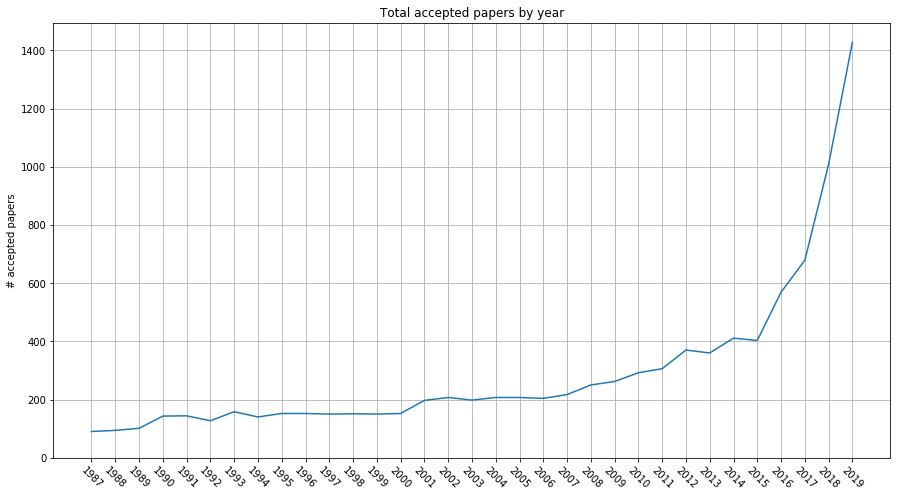

In [7]:
plt.plot(year_stats['n_accepted'])
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Total accepted papers by year')
plt.ylabel('# accepted papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

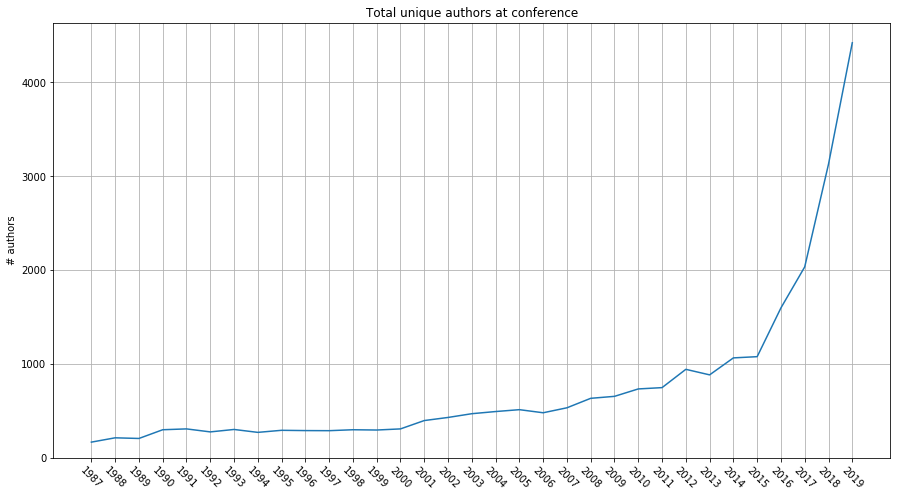

In [8]:
plt.plot(year_stats['unique_authors'])
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Total unique authors at conference')
plt.ylabel('# authors')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

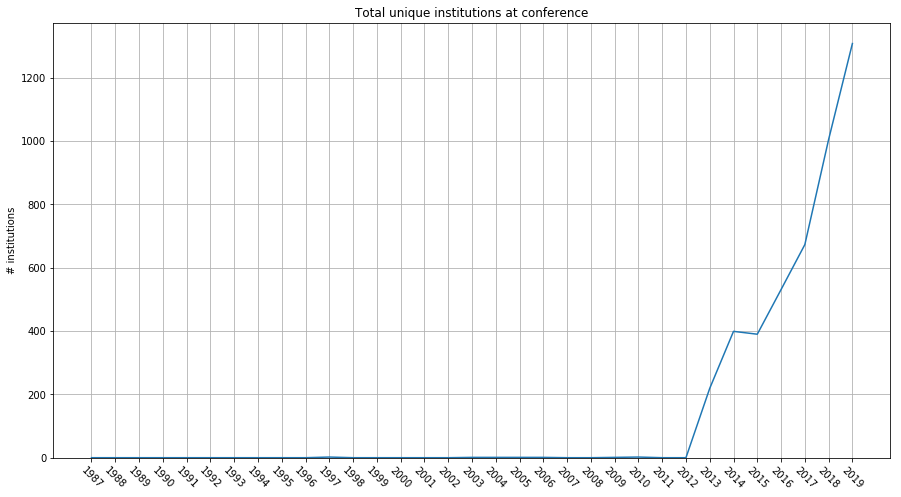

In [9]:
plt.plot(year_stats['unique_institutions'])
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Total unique institutions at conference')
plt.ylabel('# institutions')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

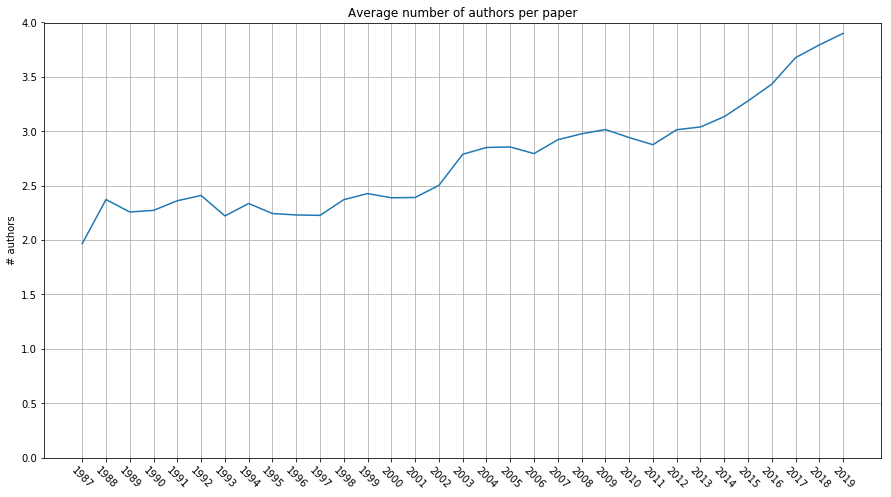

In [10]:
plt.plot(year_stats['avg_authors_per_paper'])
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average number of authors per paper')
plt.ylabel('# authors')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

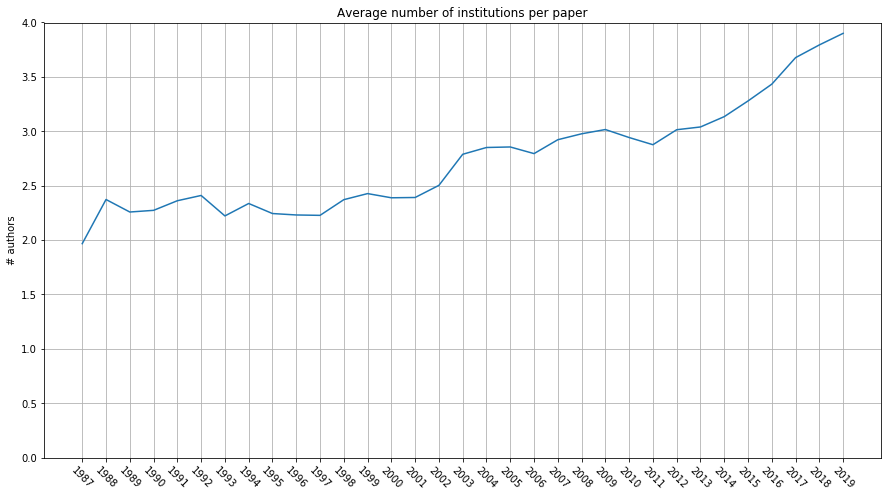

In [11]:
plt.plot(year_stats['avg_institutions_per_paper'])
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average number of institutions per paper')
plt.ylabel('# authors')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

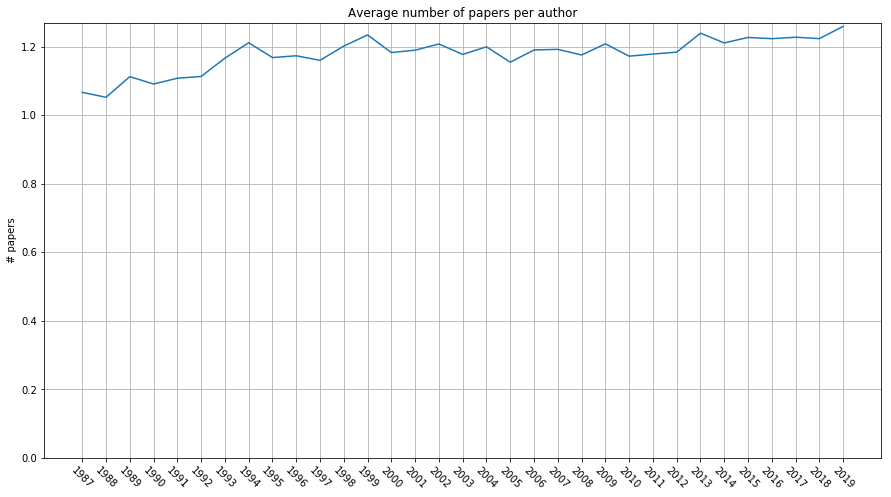

In [12]:
plt.plot(year_stats['avg_papers_per_author'])
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average number of papers per author')
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

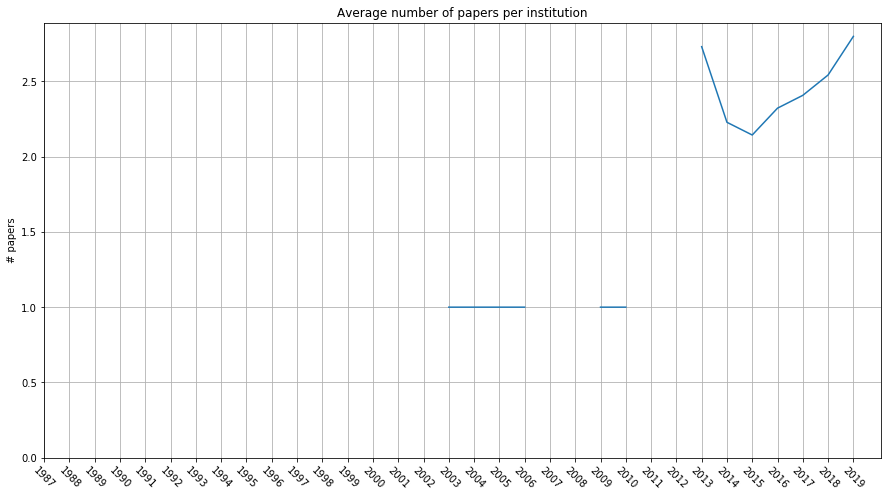

In [13]:
plt.plot(year_stats['avg_papers_per_institution'])
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average number of papers per institution')
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

## Qualitative analysis


Here I would like to investigate more 
- [TODO] average number of citations per paper (although this is biased as older papers have been around more)





Quality of reviews:
- number of reviews per paper
- average reviewer confidence
- average review length


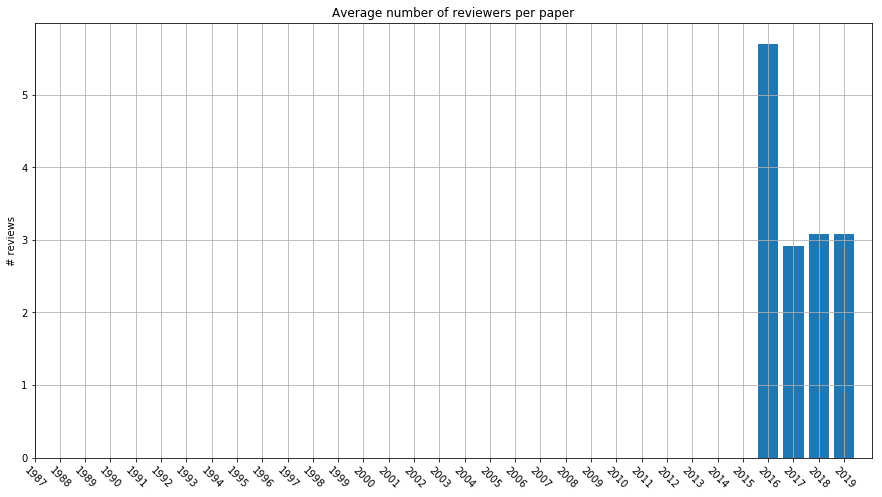

In [14]:
plt.bar(np.arange(len(conf_data)), year_stats['review_avg_num'])
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average number of reviewers per paper')
plt.ylabel('# reviews')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

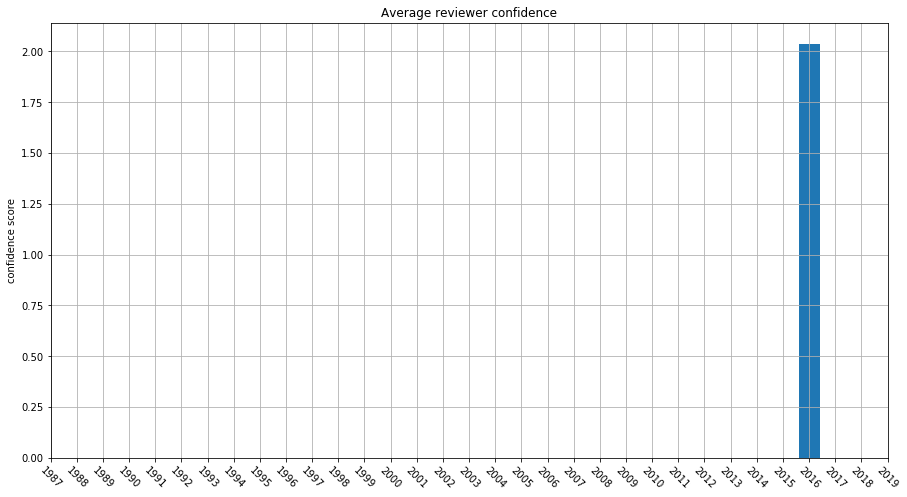

In [15]:
plt.bar(np.arange(len(conf_data)), year_stats['review_avg_confidence'])
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average reviewer confidence')
plt.ylabel('confidence score')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

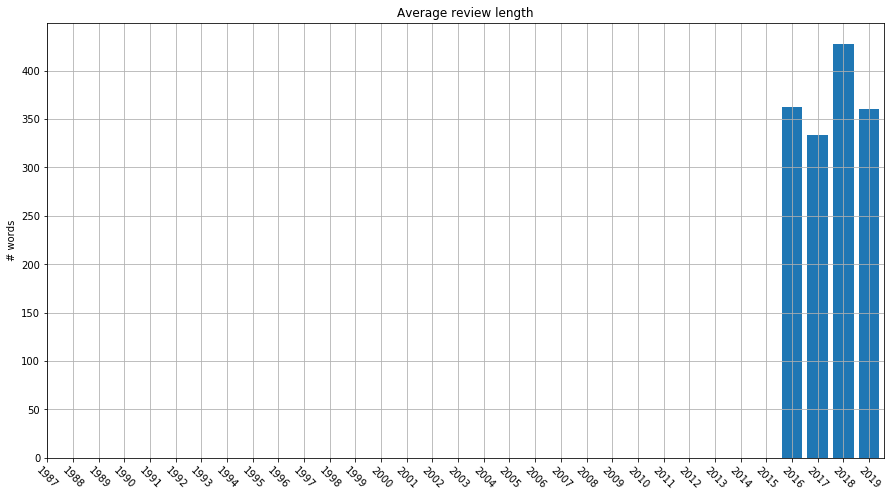

In [16]:
plt.bar(np.arange(len(conf_data)), year_stats['review_avg_length'])
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average review length')
plt.ylabel('# words')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

Paper title:
- average title length
- use of abbreviations in the title
- "All you need" in the title

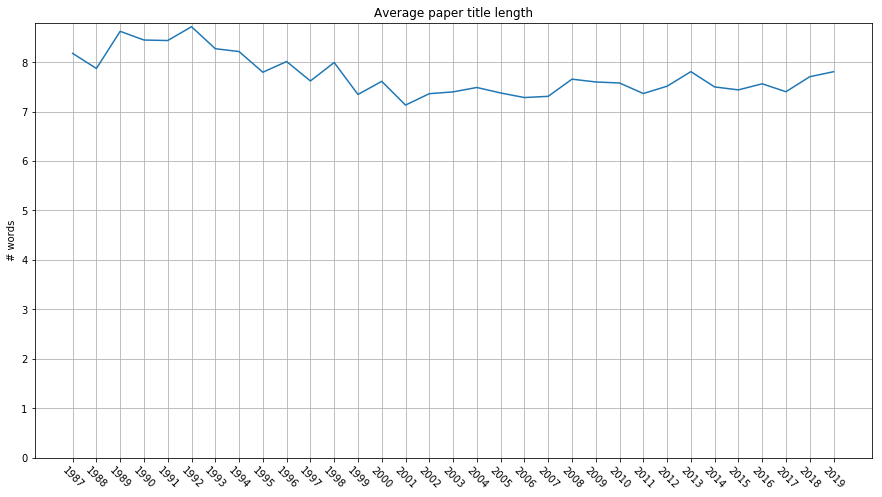

In [17]:
plt.plot(year_stats['len_title'])
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average paper title length')
plt.ylabel('# words')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

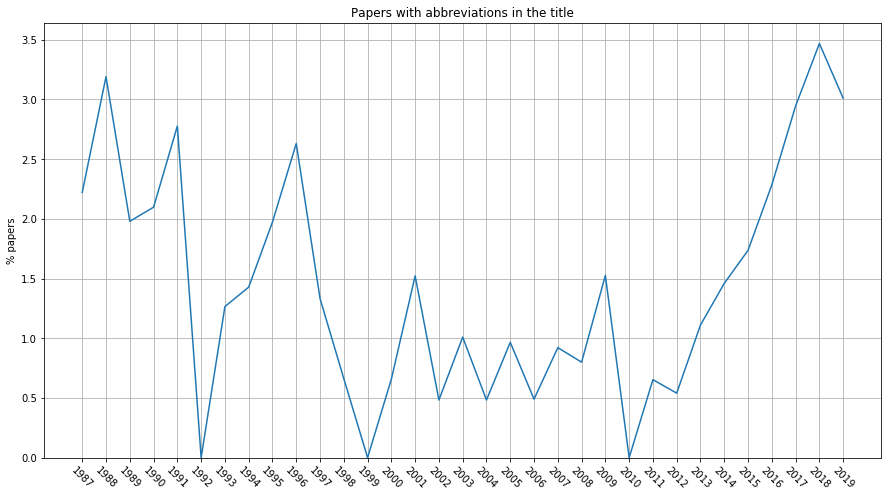

In [18]:
plt.plot(year_stats['abbrev_title'])
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Papers with abbreviations in the title')
plt.ylabel('% papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

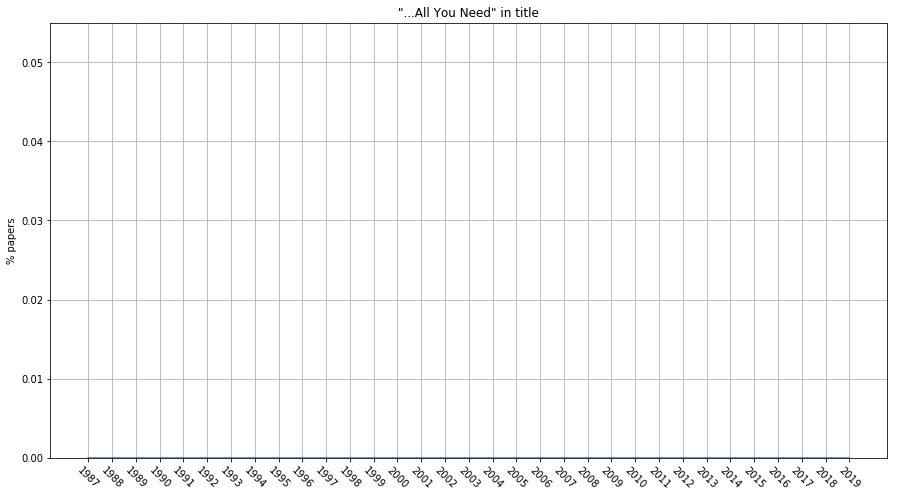

In [19]:
plt.plot(year_stats['title_ayn'])
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('"...All You Need" in title')
plt.ylabel('% papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

Paper Abstract:
- average abstract length
- average abstract word length
- average abstract word complexity

Paper content:

- average paper word length
- average paper word complexity

Although since the paper content has probably been parsed from a PDF it is possible that these numbers might be a bit off

---

Supplementary material
- total number of papers containing some type of supplementary material (pdf or zip)
- average number of papers containing some type of supplementary material (pdf or zip)

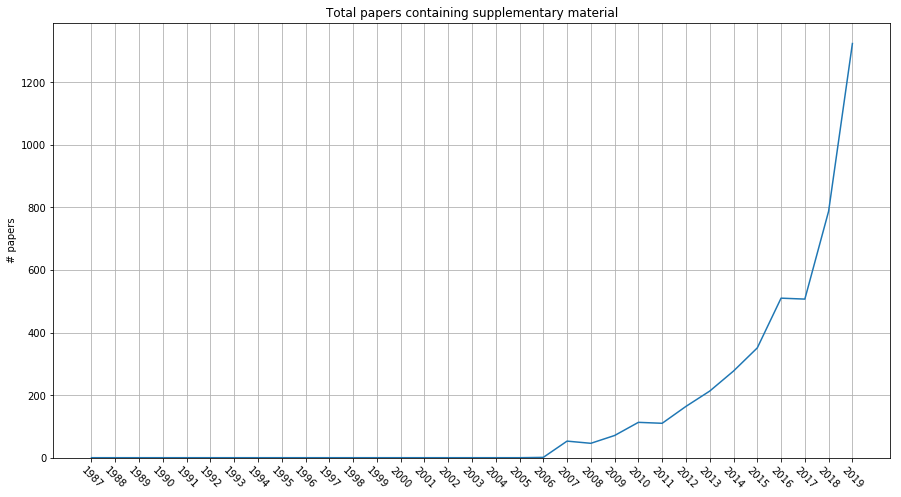

In [20]:
plt.plot(total_supplementary)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Total papers containing supplementary material')
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

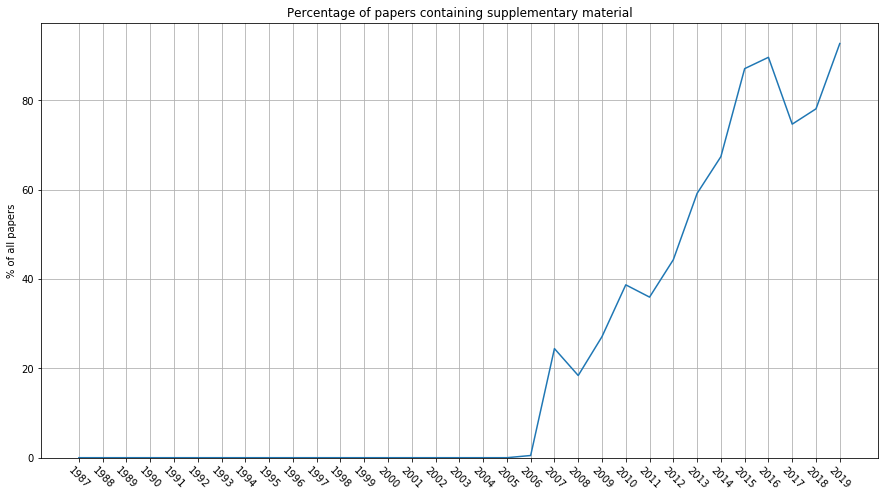

In [21]:
plt.plot(avg_supplementary)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Percentage of papers containing supplementary material')
plt.ylabel('% of all papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

---

## Correlation analysis
[WARNING!] correlation != causation

---

## Trends analysis

- average number of papers within authors first 5 years (aimed at estimating PhD student "productivity")
- average number of first-time authors

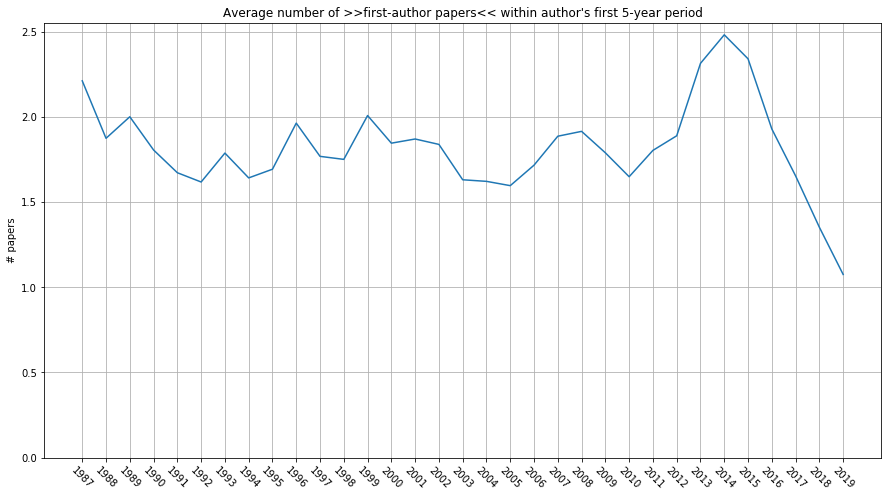

In [22]:
plt.plot(phd_productivity.values())
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title("Average number of >>first-author papers<< within author's first 5-year period")
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(phd_productivity)), sorted(phd_productivity.keys()), rotation=-45)
plt.grid()
plt.show()

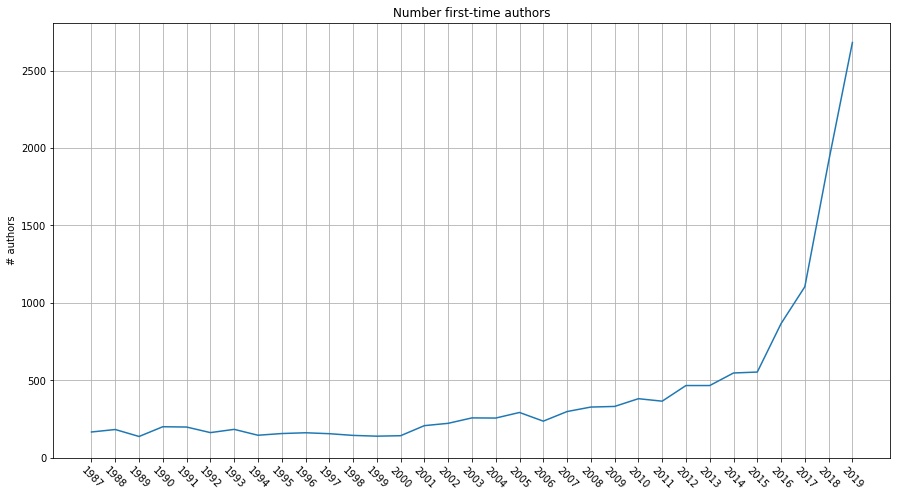

In [23]:
plt.plot(phd_numbers.values())
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title("Number first-time authors")
plt.ylabel('# authors')
plt.ylim(0)
plt.xticks(np.arange(len(phd_numbers)), sorted(phd_numbers.keys()), rotation=-45)
plt.grid()
plt.show()

- number of papers containing an abbreviation (if there is at least one all-caps word in the title)

- Most popular word / phrase - try different n-grams

- Institution with most accepted papers - top X and show their ratios as area proportions - show in legend by color

- Author with most accepted papers - same as institutions - conference Gini index - total amount of papers per author

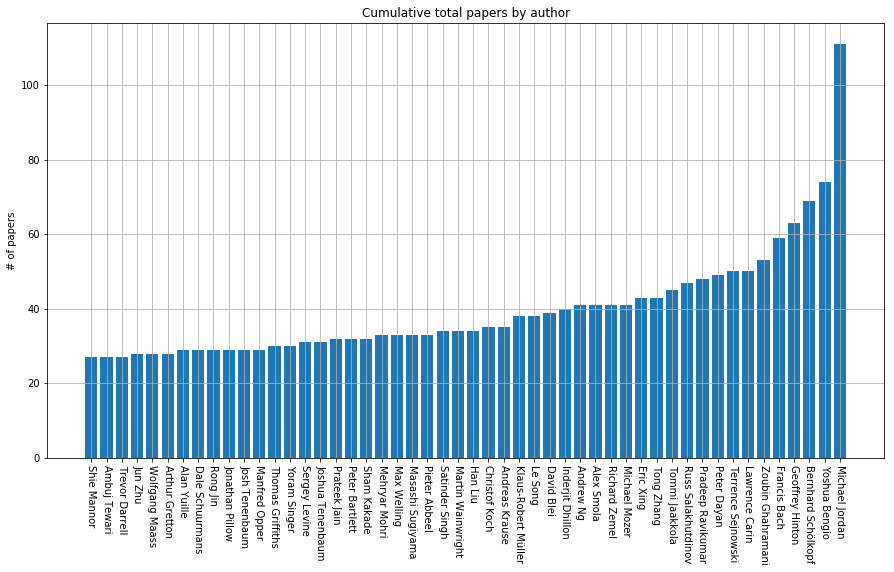

In [24]:
n_papers = [list(vv.values())[0] for vv in total_authors_sorted][-50:]
n_authors = [list(vv.keys())[0] for vv in total_authors_sorted][-50:]

plt.bar(np.arange(len(n_papers)), n_papers)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Cumulative total papers by author')
plt.ylabel('# of papers')
plt.ylim(0)
plt.xticks(np.arange(len(n_authors)), n_authors, rotation=-90)
plt.grid()
plt.show()

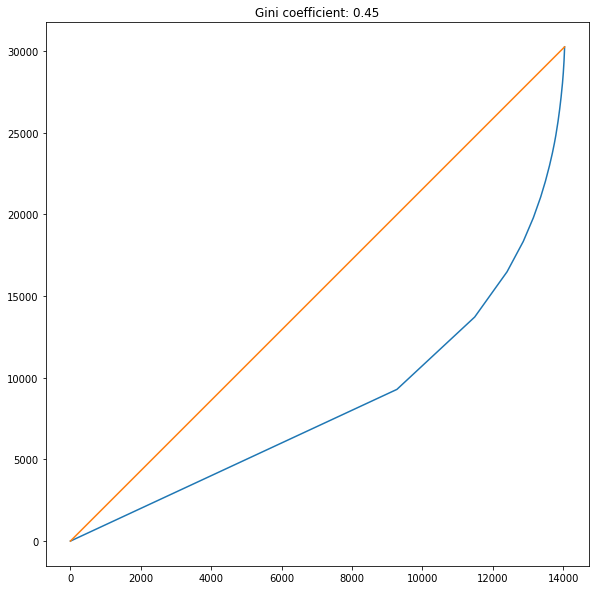

In [25]:
gg = [list(vv.values())[0] for vv in total_authors_sorted]
share_real = np.cumsum(gg)
share_ideal = np.cumsum(np.ones_like(share_real) * share_real[-1] / len(share_real))
share_diff = np.sum(share_ideal - share_real)
gini_coef = share_diff / np.sum(share_ideal)
plt.plot(share_real)
plt.plot(share_ideal)
# plt.axis('')
plt.title("Gini coefficient: {}".format(gini_coef.round(2)))
plt.gca().set_aspect(1/(share_ideal[-1]/len(share_ideal)), adjustable='box')
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

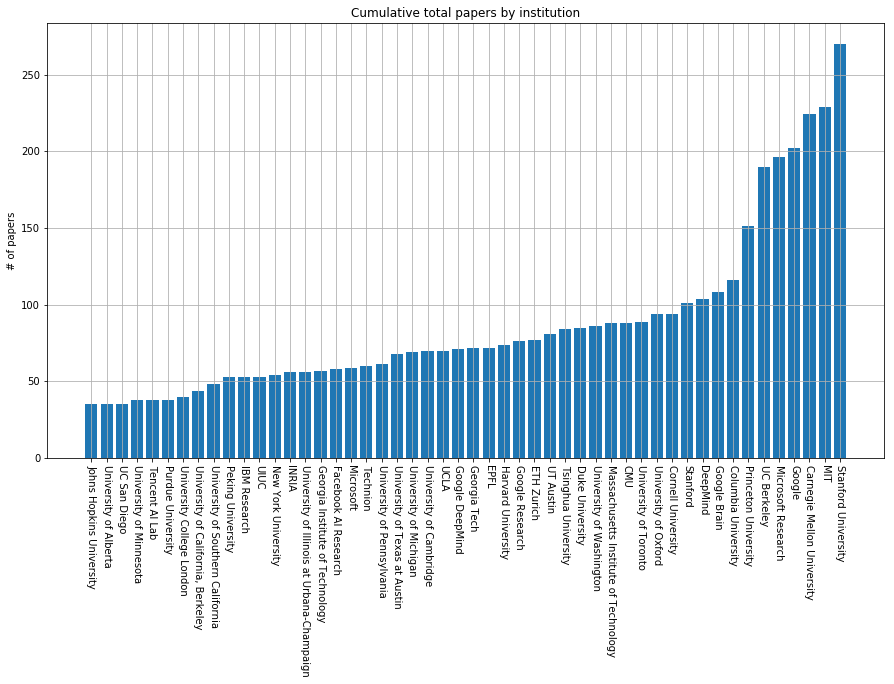

In [26]:
n_papers = [list(vv.values())[0] for vv in total_institutions_sorted][-50:]
n_institutions = [list(vv.keys())[0] for vv in total_institutions_sorted][-50:]

plt.bar(np.arange(len(n_papers)), n_papers)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Cumulative total papers by institution')
plt.ylabel('# of papers')
plt.ylim(0)
plt.xticks(np.arange(len(n_institutions)), n_institutions, rotation=-90)
plt.grid()
plt.show()

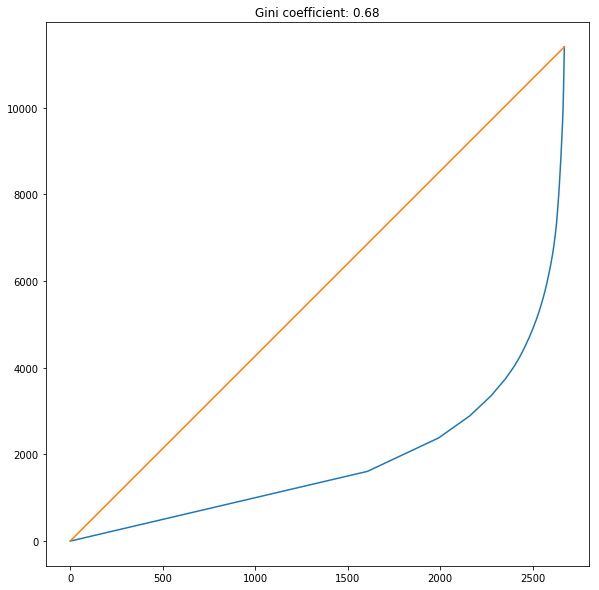

In [27]:
gg = [list(vv.values())[0] for vv in total_institutions_sorted]
share_real = np.cumsum(gg)
share_ideal = np.cumsum(np.ones_like(share_real) * share_real[-1] / len(share_real))
share_diff = np.sum(share_ideal - share_real)
gini_coef = share_diff / np.sum(share_ideal)
plt.plot(share_real)
plt.plot(share_ideal)
plt.title("Gini coefficient: {}".format(gini_coef.round(2)))
plt.gca().set_aspect(1/(share_ideal[-1]/len(share_ideal)), adjustable='box')
fig = plt.gcf()
fig.set_size_inches(10, 10)
# http://kimberlyfessel.com/mathematics/applications/gini-use-cases/
# 

## Inclusivity Data

- Country's GDP vs number of papers

This is a very rough approximate as country data was not given, and I tried to obtain country data from unstructured Institution names. This procedure consists of checking Location identifier on Wikipedia page of a given institution name. A better option was Google's answer box when searching "INSTITUTION_NAME country name" however, I was unable to access this information, and SERPAPI Google's API for scraping is not free.

Regarding GDP info, I downloaded the spreadsheet file from https://databank.worldbank.org/data/download/GDP.xls and parsed the data for the exctracted countries for 2019.

As expected we can see a slight positive correlation between the country's GDP and the paper output its institutions produced. To quantify the correlation, I calculated the Pearson's correlation coefficient ($\rho = 0.7$).

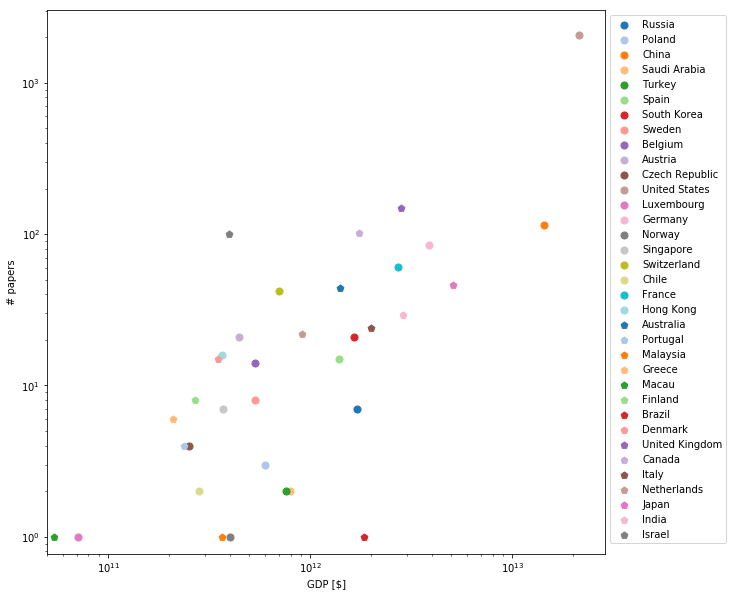

In [29]:
with open('data/country_gdp.pkl', 'rb') as handle:
    country_gdp = pickle.load(handle)
with open('data/country_papers.pkl', 'rb') as handle:
    country_papers = pickle.load(handle)
    
data_gdp = []
data_paper = []

# Plot datapoints
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
NUM_COLORS = len(country_papers)
cm = plt.get_cmap('tab20')
ax.set_prop_cycle('color', [cm(i % 20) for i in range(NUM_COLORS)])
for i, c_names in enumerate(country_papers.keys()):
    if c_names in country_gdp.keys():
        data_gdp.append(country_gdp[c_names])
        data_paper.append(country_papers[c_names])
        ax.scatter(country_gdp[c_names], country_papers[c_names], s=50, label=c_names, marker='o' if i<20 else 'p')
# Calculate the pearson's correlation coefficient

# Plot
ax.set_xlabel('GDP [$]')
ax.set_ylabel('# papers')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(ncol=1, loc='upper left', bbox_to_anchor=(1, 0., 1, 1))
plt.show()

- Ratio of author sex over the years

Although this is an important indicator of diversity, such author information is not available from the NeurIPS paper website. It is possible to get a very rough estimate based on the author's given name by comparing it to a name database. Similarly to the GDP results, this should be taken with a grain of salt, as some of the given names which are abbreviated or ambiguous have been classified as 'unknown'.